In [28]:
from brian2 import *
%matplotlib inline

#basic neuronal group characteristics
neurons_num = 12 #referring to the number of stuctures and subgroups sizes

v_rest = -70*mV #resting potential
v_th = -50*mV #threshold potential
area = 0.785*umetre**2
Cm = 1*ufarad*cm**-2 * area
v_eK = -90*mV
v_eNa = 50*mV
g_Na = 100*msiemens*cm**-2 * area
g_K = 30*msiemens*cm**-2 * area
VT = -63*mV


#Hodgkin-Huxley model equations
eqs = '''
dv/dt = -(g_Na*(m*m*m)*h*(v-v_eNa) + g_K*(n*n*n*n)*(v-v_eK) + I_stim)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I_stim : amp

'''

#glutamate
model_eqs_glu = '''
receptors_num : 1
v_e : volt
W : metre**3
Kd : mM
gam : siemens
L : mM
dI_stim_syn/dt = (receptors_num*(v - v_e)*gam*((L/W/Kd)/(1*metre**-3 + (L/W/Kd))))/ms : amp (clock-driven)

'''

#gaba
model_eqs_gaba = '''
receptors_num : 1
v_e : volt
W : metre**3
Kd : mM
gam : siemens
L : mM
dI_stim_syn/dt = (receptors_num*(v - v_e)*gam*((L/W/Kd)/(1*metre**-3 + (L/W/Kd))))/ms : amp (clock-driven)

'''


In [ ]:
Prototype = NeuronGroup(neurons_num, eqs, threshold='v > v_th', reset='v = v_rest')
Prototype.v = v_rest

# Mapping subgroups by cerebellum integration circuit
MC_in = Prototype[0]
DSGo = Prototype[1]
DSNoGo = Prototype[2]
GPi = Prototype[3]
GPe = Prototype[5]
STN = Prototype[6]
Th = Prototype[4]
MC_out = Prototype[11]

Pons = Prototype[7]
CC = Prototype[8]
DN = Prototype[9]

SNc = Prototype[10]
#Glu = Prototype[1, 2, 4, 7, 8, 11]
#GABA = Prototype[3, 4, 5, 9]

ВОЗБУЖДАЮЩИЕ СИНАПСЫ

In [ ]:
#Setting up synapses
#excitatory synapses (glutamate)
S_012 = Synapses(Prototype, Prototype, model = Equations(model_eqs_glu), on_pre='L = 1.1*mM')
S_012.connect(i=MC_in, j=[1, 2])
S_012.receptors_num = 2400
S_012.v_e = +55*mV
S_012.gam = 10*psiemens
S_012.W = 20*nmeter * area
S_012.Kd = 500*nM


S_411 = Synapses(Prototype, Prototype, model = Equations(model_eqs_glu), on_pre='L = 1.1*mM')
S_411.connect(i=Th, j=MC_out)
S_411.receptors_num = 2410
S_411.v_e = +55*mV
S_411.gam = 10*psiemens
S_411.W = 20*nmeter * area
S_411.Kd = 500*nM

#cerebellum route
S_07 = Synapses(Prototype, Prototype, model = Equations(model_eqs_glu), on_pre='L = 1.1*mM')
S_07.connect(i=MC_in, j=Pons)
S_07.receptors_num = 2420
S_07.v_e = +55*mV
S_07.gam = 10*psiemens
S_07.W = 20*nmeter * area
S_07.Kd = 500*nM

S_78 = Synapses(Prototype, Prototype, model = Equations(model_eqs_glu), on_pre='L = 1.1*mM')
S_78.connect(i=Pons, j=CC)
S_78.receptors_num = 2430
S_78.v_e = +55*mV
S_78.gam = 10*psiemens
S_78.W = 20*nmeter * area
S_78.Kd = 500*nM

S_94 = Synapses(Prototype, Prototype, model = Equations(model_eqs_glu), on_pre='L = 1.1*mM')
S_94.connect(i=DN, j=Th)
S_94.receptors_num = 2440
S_94.v_e = +55*mV
S_94.gam = 10*psiemens
S_94.W = 20*nmeter * area
S_94.Kd = 500*nM


ТОРМОЗЯЩИЕ СИНАПСЫ

In [ ]:
#inhibitory synapses (GABA)
S_13 = Synapses(Prototype, Prototype, model = Equations(model_eqs_gaba), on_pre='L = 4*mM')
S_13.connect(i=DSGo, j=GPi)
S_13.receptors_num = 2450
S_13.v_e = -65*mV
S_13.gam = 8*psiemens
S_13.W = 20*nmeter * area
S_13.Kd = 128*nM

S_25 = Synapses(Prototype, Prototype, model = Equations(model_eqs_gaba), on_pre='L = 4*mM')
S_25.connect(i=DSNoGo, j=GPe)
S_25.receptors_num = 2450
S_25.v_e = -65*mV
S_25.gam = 8*psiemens
S_25.W = 20*nmeter * area
S_25.Kd = 128*nM
                

S_53 = Synapses(Prototype, Prototype, model = Equations(model_eqs_gaba), on_pre='L = 4*mM')
S_53.connect(i=GPe, j=GPi)
S_53.receptors_num = 2460
S_53.v_e = -65*mV
S_53.gam = 8*psiemens
S_53.W = 20*nmeter * area
S_53.Kd = 128*nM

S_34 = Synapses(Prototype, Prototype, model = Equations(model_eqs_gaba), on_pre='L = 4*mM')
S_34.connect(i=GPi, j=Th)
S_34.receptors_num = 2470
S_34.v_e = -65*mV
S_34.gam = 8*psiemens
S_34.W = 20*nmeter * area
S_34.Kd = 128*nM


#cerebellum route
S_89 = Synapses(Prototype, Prototype, model = Equations(model_eqs_gaba), on_pre='L = 4*mM')
S_89.connect(i=CC, j=DN)
S_89.receptors_num = 25000
S_89.v_e = -65*mV
S_89.gam = 8*psiemens
S_89.W = 20*nmeter * area
S_89.Kd = 128*nM



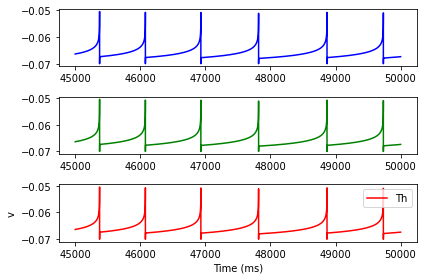

In [38]:
import numpy as np
import matplotlib.pyplot as plt

M = StateMonitor(Prototype, 'v', record=True)

run(5000*ms)

fig, axs = plt.subplots(3)
axs[0].plot(M.t/ms, M.v[0], color='blue', label='Input')
axs[1].plot(M.t/ms, M.v[11], color='green', label='Output')
axs[2].plot(M.t/ms, M.v[4], color='red', label='Th')
plot()

xlabel('Time (ms)')
ylabel('v')
legend();

# set the spacing between subplots
fig.tight_layout()
plt.show()

Скопление уравнений, выражений, переменных etc., которые находятся на доработке/переосмыслении:

In [ ]:
#trash
#dn/dt = ((0.01*(10 + v))/(exp((10 + v)/10) - 1))*(1-n) - (0.125*exp(v/80))*n : 1
#dm/dt = ((0.1*(25 + v))/(exp((25 + v)/10) - 1))*(1-m) - (4*exp(v/18))*m : 1
#dh/dt = 0.07*exp(v/20)*(1-h) - (1/(exp((30 + v)/10) + 1))*h : 1

#dL/dt = -0.3*10**-6/ms : mol (event-driven)
#dL/dt = -1.2*10**-6/ms : mol (event-driven)

#S_exc.connect(i=SNc, j=DSGo)
#S_inh.connect(i=SNc, j=DSNoGo)

#synapses parameters
#S_exc.receptors_num = 2500
#S_exc.v_e = +55*mV
#S_exc.gam = 10*psiemens
#S_exc.W = 20*nmeter * area
#S_exc.Kd = 500*nM

#synapses parameters
#S_inh.receptors_num = 2500
#S_inh.v_e = -65*mV
#S_inh.gam = 8*psiemens
#S_inh.W = 20*nmeter * area
#S_inh.Kd = 128*nM